In [1]:
from IPython.core.display import display, HTML, Image
display(HTML("<style>.container {width:100% !important;}</style>"))

import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="0"

# %config Completer.use_jedi=False

%config IPCompleter.use_jedi = False
%load_ext autoreload
%autoreload 2

In [2]:
import cv2
import yaml
import torch
import numpy as np
from pathlib import Path
from omegaconf import OmegaConf
import torchvision as tv
from torchvision.utils import make_grid
from ipywidgets import interact
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch.nn as nn

import pytorch_tools as pt
from pytorch_tools.utils.misc import count_parameters

from src.arg_parser import TrainLoaderConfig, ValLoaderConfig
from src.dali_dataloader import DaliLoader
from src.model import CModel
# from src.angular_losses import SphereLinearLayer

from torchvision.models import resnet34
count = lambda x: pt.utils.misc.count_parameters(x)[0]

2021-07-28 17:08:50.517 | WARNING  | pytorch_tools.modules:<module>:35 - Inplace ABN is not installed. Using ABN by default


# Misc

In [151]:
path = "logs/2021-07-24_nf-repvgg_fix-shuffle_stats_regnet-attn/10-18/"
# path = 'logs/2021-07-27_nf_conv-act_ortho/21-02/'
# path = "configs/hydra_exp/26.nf_conv-act_my-self-attn.yaml"
cfg = OmegaConf.load(path + '/config.yaml')
cmodel = cmodel = CModel(cfg.model.layer_config, cfg.model.extra_kwargs)
print(f"{count(cmodel) / 1e6:.2f} M params")

16.92 M params


In [153]:
sd = torch.load(path + "/model.chpn", map_location=lambda storage, loc: storage.cpu())["state_dict"]
cmodel.load_state_dict(sd)

In [145]:
from src.callbacks import OrthoLoss

In [154]:
OrthoLoss(cmodel)()

tensor(1506.5212, grad_fn=<AddBackward0>)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


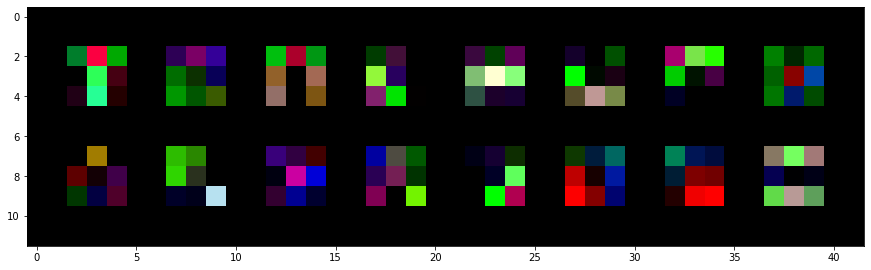

In [100]:
cc = cmodel.layers[0].conv.weight.detach()
plt.figure(figsize=(15, 20))
plt.imshow(make_grid(cc, nrow=2).transpose(0, 2))

In [71]:
torch.hstack(torch.split(cmodel.layers[0].conv.weight)

TypeError: hstack(): argument 'tensors' (position 1) must be tuple of Tensors, not Parameter

In [70]:
cmodel.layers[0].conv.weight.shape.

torch.Size([16, 3, 3, 3])

tensor(4.1598, grad_fn=<CopyBackwards>)

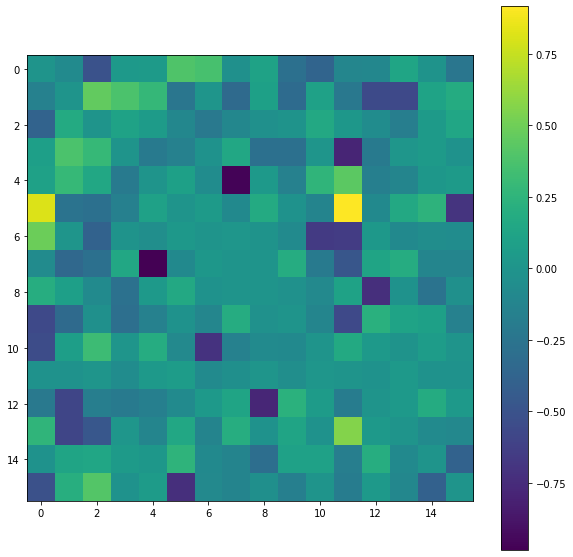

In [64]:
cc = cmodel.layers[0].conv.weight
mat = cc.view(cc.size(0), -1)
corr = mat @ mat.T / (mat.norm(dim=-1).pow(2) + 1e-3) - torch.eye(mat.size(0))
plt.figure(figsize=(10, 10))
plt.imshow(corr.detach())
plt.colorbar()
corr.norm()

In [14]:
cmodel

CModel(
  (layers): ModuleList(
    (0): ConvActBlock(
      (res_downscale): BlurPool(channels=3)
      (conv): Sequential(
        (0): ParametrizedConv2d(
          3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False
          (parametrizations): ModuleDict(
            (weight): ParametrizationList(
              (0): _SpectralNorm()
            )
          )
        )
        (1): Affine(value=1.0, trainable=True)
      )
      (shuffle): Identity()
      (act): Hardswish()
      (attn): Identity()
    )
    (1): ConvActBlock(
      (res_downscale): Identity()
      (conv): Sequential(
        (0): ParametrizedConv2d(
          16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False
          (parametrizations): ModuleDict(
            (weight): ParametrizationList(
              (0): _SpectralNorm()
            )
          )
        )
        (1): Affine(value=0.5, trainable=True)
      )
      (shuffle): Identity()
      (act): Hardswish()
      (a

In [13]:
cmodel(torch.rand(1, 3, 64, 64)).shape

torch.Size([1, 1000])

In [ ]:
# sd = torch.load("/home/zakirov/repoz/sota_imagenet/logs/2021-07-02_cnet_no-dim-red_nov/10-37-30/model.chpn")['state_dict']
# my nfnet
sd = torch.load("/home/zakirov/repoz/sota_imagenet/logs/2021-07-08_nf-cnet_more-heads/11-23/model.chpn", map_location='cpu')['state_dict']
# timm nfnet stem
# sd = torch.load("/home/zakirov/repoz/sota_imagenet/logs/2021-07-08_eca-nfnet-l0_long-more-aug/11-06/model.chpn", map_location='cpu')['state_dict']

In [ ]:
ww = sd['layers.1.weight']
ww2 = ww.view(64, 2, 2, 3, 3, 3).permute(0, 3, 4, 1, 5, 2).reshape(64, 3, 6, 6)
grid = make_grid(ww2.mul(2)).permute(1, 2, 0)

# grid = make_grid(sd['stem.conv1.weight'].mul(3)).permute(1, 2, 0)
plt.figure(figsize=(10, 10))
plt.imshow(grid)

# Speed test

In [ ]:
cmodel = CModel(layer_config, extra_kwargs)
pt.utils.misc.initialize(cmodel, gamma=1.71)
for m in cmodel.modules():
    if isinstance(m, torch.nn.Conv2d):
        m.weight.data.copy_(pt.utils.misc.normalize_conv_weight(m.weight, gamma=1.4))
cmodel_c = add_hooks(deepcopy(cmodel))
out_c = cmodel_c(inp)
out_c.mean(), out_c.std()

In [ ]:
pt.utils.misc.initialize(cmodel, gamma=1.72)

In [ ]:
import timm.models as t_models

In [ ]:
eca_nfn = t_models.nfnet.eca_nfnet_l0(drop_rate=0., drop_path_rate=0.1).eval().requires_grad_(False) #.cuda()

In [ ]:
t0 = benchmark.Timer(
    stmt='model(inp)',
    globals={'inp': inp, 'model': bmodel},
    label='some label',
    sub_label=f'BModel (old)',
    description='description',
).blocked_autorange(min_run_time=1)

t1 = benchmark.Timer(
    stmt='model(inp)',
    globals={'inp': inp, 'model': cmodel},
    label='some label',
    sub_label=f'CModel (new)',
    description='description',
).blocked_autorange(min_run_time=1)

benchmark.Compare([t0, t1]).print()

# Loader

In [3]:
BS = 16
NUM_WORKERS = 4
# pipe = train_pipeline(batch_size=BS, num_threads=1, device_id=0)
# pipe.build()


In [ ]:
cfg = TrainLoaderConfig(
    batch_size=16,
#     color_twist_prob=0.1,
    gray_prob=0.3,
#     re_prob=0.2,
#     re_count=4,
    use_tfrecords=True,
    root_data_dir=Path('/gpfs/gpfs0/emil.zakirov/datasets/ImageNet_2012/raw-data')
)

# cfg = ValLoaderConfig(
#     batch_size=8,
#     use_tfrecords=True,
#     root_data_dir=Path('/mnt/storage/datasets/ImageNet/raw-data/')
# )
loader = DaliLoader(cfg=cfg)
batch = next(iter(loader))

In [ ]:
def show_batch(batch):
    batch = make_grid(batch.cpu(), nrow=4).transpose(-1, -2).transpose(-1, -3).numpy()
    batch = (batch * 0.2 + 0.5)    
    plt.imshow(batch)

plt.figure(figsize=(24, 12))
show_batch(batch[0])

# Evaluate

In [ ]:
INP = torch.ones(2, 3, 224, 224).cuda()
PRED = torch.ones(2, 1000).cuda()
LOSS = pt.losses.CrossEntropyLoss().cuda()
METRIC = [pt.metrics.Accuracy(), pt.metrics.Accuracy(5)]
class Foo: # used to stack and then inspect all predictions
    def __init__(self):
        self.name = "Foo"
    def __call__(self, *args, **kwargs):
        return torch.tensor(0)
    
@torch.no_grad()
def evaluate_model(model, size=224, rect=False, **kwargs):
    """Eval model on ImageNet validation dataset"""
    BS = 25 if size >= 384 else 125
    if rect:
        val_loader = ValRectLoader(bs=BS, workers=12, **kwargs)
    else:
        val_loader = DaliLoader(False, bs=BS, sz=size, workers=12, **kwargs)
    model = model.eval().cuda()
    runner = pt.fit_wrapper.Runner(
        model,
        None,
        LOSS,
        callbacks=[
            pt.fit_wrapper.callbacks.BatchMetrics(METRIC),
            pt.fit_wrapper.callbacks.LoaderMetrics(Foo()),
            pt.fit_wrapper.callbacks.ConsoleLogger(),
        ],
        use_fp16=True,
    )
    runner.callbacks.on_begin()
    _, (acc1, acc5, foo) = runner.evaluate(val_loader)
    print(f"Acc@1: {acc1:.2f}. Acc@5: {acc5:.2f}")
    return acc1, acc5, runner

In [ ]:
# PATH = "logs/exp48.GENet_no_dim_red_ctmx_20201031_180205/"
# PATH = "logs/exp89.BNet_asoft_20201107_132233/"
PATH = "logs/exp90.BNet_asoft_ctmx_20201109_095536//"
# PATH = "logs/exp99.BNet_adacos_margin_res_20201225_112802/"
# PATH = "logs/exp92.BNet_arcsoft_20201109_194344/"
# PATH = "logs/exp92.BNet_arcsoft_64_20201110_211920/"


# PATH = "/home/zakirov/exp55.GENet_no_dim_red_ctmx_ws_20201006_182419/"
# PATH = "/home/zakirov/repoz/sota_imagenet/logs/exp56.GENet_no_dim_red_ctmx_ws_adam_20201007_072753/"
PATH = Path(PATH)
model_config = yaml.load(open(PATH / "config.yaml"))
model_config["model_params"].pop("mobilenetv3_head", None)
model_config["model_params"]["head_type"] = "default"
model = pt.models.BNet(**model_config["model_params"])
model = model.eval().requires_grad_(False).cuda()
# model = pt.modules.conv_to_ws_conv(model)
model.last_linear.weight.shape

In [ ]:
ll = nn.Linear(100, 100, bias=False)

In [ ]:
sd = torch.load(PATH / "model.chpn")["state_dict"]
model.load_state_dict(sd, strict=False)

In [ ]:
sphere_linear = SphereLinearLayer(model.last_linear.weight.size(1), model.last_linear.weight.size(0)).requires_grad_(False)
sphere_linear.load_state_dict(model.last_linear.state_dict(), strict=False)
model.last_linear = sphere_linear

In [ ]:
# R-50 GN + WS Acc@1: 76.33. Acc@5: 93.34 
# X-50-GN-WS Acc@1: 77.28. Acc@5: 93.61
# R-101 GN + WS Acc@1: 77.85. Acc@5: 93.90
# X-101-GN-WS Acc@1: 78.19. Acc@5: 93.98

In [ ]:
if (Path("val_features") / f"{PATH.name}_pred").exists():
    all_output = torch.load(f"val_features/{Path(PATH).name}_pred")
    all_target = torch.load(f"val_features/{Path(PATH).name}_true")
else:
    # calculate features and save them
    _, _, runn = evaluate_model(model, rect=True, resize_method="triang")
    all_target = torch.cat(runn.callbacks.callbacks[1].target).float()
    all_output = torch.cat(runn.callbacks.callbacks[1].output, dim=0).float()
    torch.save(all_output, f"val_features/{Path(PATH).name}_pred")
    torch.save(all_target, f"val_features/{Path(PATH).name}_true")

correct = all_output.argmax(dim=1).eq(all_target)
print(f"{correct.float().mean() * 100:.2f}")

# get embeddings by inverse of last weight matrix
class_inverse = torch.pinverse(F.normalize(model.last_linear.weight))
all_embeddings = all_output @ class_inverse.T

In [ ]:
batch_cos = all_output[:1000]
batch_true = all_target[:1000]

In [ ]:
class_vectors = F.normalize(model.last_linear.weight)

In [ ]:
class_cos = (class_vectors @ class_vectors.T)
class_cos_flat = torch.triu(class_cos, diagonal=1).flatten()
class_cos_flat = class_cos_flat[class_cos_flat != 0].sort()[0].cpu()

In [ ]:
most_sim_val, mos_sim_index = torch.triu(class_cos, diagonal=1).max(-1)[0].topk(14)
most_sim_val, mos_sim_index

In [ ]:
def lunif(x, t=2):
    sq_pdist = torch.pdist(x, p=2).pow(2)
    return sq_pdist.mul(-t).exp().mean().log()
lunif(F.normalize(model.last_linear.weight).T)
# lunif(torch.randn(1000, 128))

In [ ]:
# asoft 64
all_cls_med = []
for cls in range(1000):
    cls_med = torch.acos(all_embeddings[all_target.eq(cls)] @ class_vectors[cls]).median()
    all_cls_med.append(cls_med.item())
plt.plot(sorted(all_cls_med));
plt.show()
plt.hist(all_cls_med, bins=20);
np.mean(all_cls_med)

In [ ]:
all_output.where()

In [ ]:
torch.where()

In [ ]:
# pos_cos = all_output.gather(-1, index=all_target[..., None])
pos_cos = all_output.max(-1)[0]
pos_cos = torch.acos(pos_cos)
corr_pos_cos = pos_cos[correct]
incorr_pos_cos = pos_cos[~correct]
plt.hist(corr_pos_cos.flatten().cpu(), bins=30, alpha=0.7);
plt.hist(incorr_pos_cos.flatten().cpu(), bins=30, alpha=0.7);
plt.legend(["TP", "FP"]);

In [ ]:
# pos_cos = all_output.gather(-1, index=all_target[..., None])
pos_cos = all_output.max(-1)[0]
# pos_cos = torch.acos(pos_cos)
corr_pos_cos = pos_cos[correct]
incorr_pos_cos = pos_cos[~correct]
plt.hist(corr_pos_cos.flatten().cpu(), bins=30, alpha=0.7);
plt.hist(incorr_pos_cos.flatten().cpu(), bins=30, alpha=0.7);
plt.legend(["TP", "FP"]);

In [ ]:
torch.Tensor.scatter_add_?

In [ ]:
all_output[0, all_target[0].long()]

In [ ]:
1 + torch.tensor(10)

In [ ]:
cos = np.random.rand(100)
np.median(cos) - np.cos(np.median(np.arccos(cos)))

In [ ]:
np.log(1512602)

In [ ]:
all_output.scatter_add(dim=1, index=all_target.long()[..., None], src=torch.tensor(-10.0).expand(50000, 1))

In [ ]:
all_output.argmax(-1)

In [ ]:
m = 0.35
np.log(382433.9062) / (0.9 - m)

In [ ]:
s = 16
oo = all_output.scatter(dim=1, index=all_target.long()[..., None], value=-1)
oo.mul(16).exp().sum(-1).mean()

In [ ]:
m = 0.2
np.log(np.e ** (s * (1 - m)) + 3e5) / s

In [ ]:
((all_output).mul(16).exp().sum(-1)).mean()

In [ ]:
((all_output - all_output.max(-1)[0][..., None]).mul(16).exp().sum(-1) - 1).mean()

In [ ]:
# pos_cos = all_output.gather(-1, index=all_target[..., None])
pos_cos = all_output.max(-1)[0]
pos_cos = torch.acos(pos_cos)
corr_pos_cos = pos_cos[correct]
incorr_pos_cos = pos_cos[~correct]
plt.hist(corr_pos_cos.flatten().cpu(), bins=30, alpha=0.7);
plt.hist(incorr_pos_cos.flatten().cpu(), bins=30, alpha=0.7);
plt.legend(["TP", "FP"]);

In [ ]:
# pos_cos = all_output.gather(-1, index=all_target[..., None])
pos_cos = all_output.max(-1)[0]
pos_cos = torch.acos(pos_cos)
corr_pos_cos = pos_cos[correct]
incorr_pos_cos = pos_cos[~correct]
plt.hist(corr_pos_cos.flatten().cpu(), bins=30, alpha=0.7);
plt.hist(incorr_pos_cos.flatten().cpu(), bins=30, alpha=0.7);
plt.legend(["TP", "FP"]);

In [ ]:
pos_cos = all_output.sort(-1, descending=True)[0][5:]
pos_cos = torch.acos(pos_cos)
plt.hist(pos_cos.flatten().cpu(), bins=30, alpha=0.7);

In [ ]:
pos_cos = all_output.sort(-1, descending=True)[0][5:]
pos_cos = torch.acos(pos_cos)
plt.hist(pos_cos.flatten().cpu(), bins=30, alpha=0.7);

In [ ]:
# pos_cos = all_output.gather(-1, index=all_target[..., None])
pos_cos = all_output.max(-1)[0]
pos_cos = torch.acos(pos_cos)
corr_pos_cos = pos_cos[correct]
incorr_pos_cos = pos_cos[~correct]
plt.hist(corr_pos_cos.flatten().cpu(), bins=30, alpha=0.7);
plt.hist(incorr_pos_cos.flatten().cpu(), bins=30, alpha=0.7);
plt.legend(["TP", "FP"]);

In [ ]:
pos_cos = all_output.gather(-1, index=all_target[..., None].long())
pos_cos = torch.acos(pos_cos.float())
corr_pos_cos = pos_cos[correct]
incorr_pos_cos = pos_cos[~correct]
plt.hist(corr_pos_cos.flatten().cpu(), bins=30, alpha=0.7);
plt.hist(incorr_pos_cos.flatten().cpu(), bins=30, alpha=0.7);
plt.legend(["TP", "FN"]);
print(f"Median cos to positive: {pos_cos.median():.2f}. \n95% percentile: {np.percentile(pos_cos, 95):.2f}")

In [ ]:
pos_cos = all_output.gather(-1, index=all_target[..., None].long())
pos_cos = torch.acos(pos_cos.float())
corr_pos_cos = pos_cos[correct]
incorr_pos_cos = pos_cos[~correct]
plt.hist(corr_pos_cos.flatten().cpu(), bins=30, alpha=0.7);
plt.hist(incorr_pos_cos.flatten().cpu(), bins=30, alpha=0.7);
# plt.hist(pos_cos.flatten().cpu(), bins=60, alpha=0.7);
plt.legend(["TP", "FN"]);
print(f"Median cos to positive: {pos_cos.median():.2f}. \n95% percentile: {np.percentile(pos_cos, 95):.2f}")

In [ ]:
pos_cos = all_output.gather(-1, index=all_target[..., None].long())
pos_cos = torch.acos(pos_cos.float())
corr_pos_cos = pos_cos[correct]
incorr_pos_cos = pos_cos[~correct]
plt.hist(corr_pos_cos.flatten().cpu(), bins=30, alpha=0.7);
plt.hist(incorr_pos_cos.flatten().cpu(), bins=30, alpha=0.7);
plt.legend(["TP", "FN"]);

In [ ]:
pos_cos = all_output.gather(-1, index=all_target[..., None])
pos_cos = torch.acos(pos_cos.float())
corr_pos_cos = pos_cos[correct]
incorr_pos_cos = pos_cos[~correct]
plt.hist(corr_pos_cos.flatten().cpu(), bins=30, alpha=0.7);
plt.hist(incorr_pos_cos.flatten().cpu(), bins=30, alpha=0.7);
plt.legend(["TP", "FN"]);

In [ ]:
# plot distance to positive and si

In [ ]:
batch_cos.norm(dim=0)

In [ ]:
o1.norm(dim=0)

In [ ]:
# best classes 364, 333, 986
# not so good 963, 749, 162
from sklearn.decomposition import PCA
o1 = all_output[all_target.eq(963)]
o2 = all_output[all_target.eq(749)]
o3 = all_output[all_target.eq(986)]
oo = torch.cat([o1, o2, o3], 0)

pca_features = PCA(n_components=2).fit_transform(oo)
pca_features_norm = torch.nn.functional.normalize(torch.from_numpy(pca_features))
c = [1,] * 50 + [2,] * 50 + [3,] * 50
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
axes[0].scatter(pca_features[:, 0], pca_features[:, 1], c=c)
axes[1].scatter(pca_features_norm[:, 0], pca_features_norm[:, 1], c=c)
axes[0].set_title("PCA of features for 3 random classes on Imagenet validation")

# Model inspection

In [ ]:
model_se = pt.models.resnet50(attn_type="eca")
model_sevar3 = pt.models.resnet50(attn_type="eca9")

In [ ]:
count_parameters(model_se)[0], count_parameters(model_sevar3)[0]

In [ ]:
count(pt.modules.residual.SimpleBasicBlock(128, 128, 12))

In [ ]:
pt.modules.residual.FusedRepVGGBlock(32, 64, act=nn.ReLU)

In [ ]:
"""temporary place for experiments with model. when it's mature will move this to pytorch_tools"""


"""c_model is model with Caffe-like explicit model constructor. While it makes configs
slightly larger, it also allows much greater flexibility than using separate class for each model
"""

from dataclasses import dataclass, field
from collections import OrderedDict
from typing import List, Dict, Union


import torch
import torch.nn as nn

import pytorch_tools as pt
from pytorch_tools.utils.misc import listify
from pytorch_tools.modules.residual import conv1x1, conv3x3, DropConnect
from pytorch_tools.modules import ABN


## some blocks defintion

class PreBasicBlock(nn.Module):
    """BasicBlock with preactivatoin & without downsample support"""

    def __init__(
        self, in_chs, out_chs, mid_chs=None, groups=1, groups_width=None, norm_layer=ABN, norm_act="relu", keep_prob=1,
    ):
        super().__init__()
        self.in_chs = in_chs
        self.out_chs = out_chs
        mid_chs = mid_chs or out_chs
        groups = in_chs // groups_width if groups_width else groups
        layers = [
            ("bn1", norm_layer(in_chs, activation=norm_act)),
            ("conv1", conv3x3(in_chs, mid_chs)),
            ("bn2", norm_layer(mid_chs, activation=norm_act)),
            ("conv2", conv3x3(mid_chs, out_chs)),
            ("droppath", DropConnect(keep_prob))
        ]
        self.block = nn.Sequential(OrderedDict(layers))

    def forward(self, x):
        out = self.block(x)
        if self.in_chs == self.out_chs:
            out += x
        else:
            out[:, :self.in_chs] += x
        return out

class PreInvertedResidual(nn.Module):
    def __init__(
        self,
        in_chs,
        out_chs,
        mid_chs=None,
        keep_prob=1,  # drop connect param
        norm_layer=ABN,
        norm_act="relu",
    ):
        super().__init__()
        self.in_chs = in_chs
        self.out_chs = out_chs
        mid_chs = mid_chs or out_chs
        layers = [
            ("bn1", norm_layer(in_chs, activation=norm_act)),
            ("conv_pw", conv1x1(in_chs, mid_chs)),
            ("bn2", norm_layer(mid_chs, activation=norm_act)),
            ("conv_dw", conv3x3(mid_chs, mid_chs, groups=mid_chs)),
            ("bn3", norm_layer(mid_chs, activation=norm_act)),
            ("conv_pw2", conv1x1(mid_chs, out_chs)),
            ("droppath", DropConnect(keep_prob))
        ]
        self.block = nn.Sequential(OrderedDict(layers))

    def forward(self, x):
        out = self.block(x)
        if self.in_chs == self.out_chs:
            out += x
        else:
            out[:, :self.in_chs] += x
        return out


@dataclass
class LayerDef:
    # previous layer
    prev_l: int
    # number of repeats
    n: int
    # which layer
    module: Union[str, nn.Module]
    args: List = field(default_factory=lambda: tuple())
    kwargs: Dict = field(default_factory=lambda: dict())


class Concat(nn.Module):
    def forward(self, *args):
        return torch.cat(*args, dim=1)


class CModel(nn.Module):
    """
    Args:
        features_idx (List[int]):
            from which layers to additionally save features
    """

    def __init__(
        self, layer_config: List[LayerDef], extra_kwargs: Dict[str, Dict] = None, features_idx: List[int] = None,
    ):
        super().__init__()
        if not isinstance(layer_config[0], LayerDef):
            layer_config = [LayerDef(*l) for l in layer_config]
        if extra_kwargs is not None:
            self._update_config_with_extra_params(layer_config, extra_kwargs)
        layers, saved = self._parse_config(layer_config)
        self.layers: nn.Module = layers
        self.saved: List[int] = saved

    @staticmethod
    def _update_config_with_extra_params(layer_config: List[LayerDef], extra_kwargs: Dict[str, Dict]):
        for l_name, l_kwargs in extra_kwargs.items():
            for l in layer_config:
                if l.module == l_name:
                    l.kwargs.update(**l_kwargs)
        
    @staticmethod
    def _parse_config(layer_config: List[LayerDef]):
        saved = []
        layers = []
        for l_idx, l in enumerate(layer_config):
            l.module = eval(l.module) if isinstance(l.module, str) else l.module  # eval strings
            l.args = [eval(i) if isinstance(i, str) else i for i in listify(l.args)]
            l.kwargs = {k: (eval(v) if isinstance(v, str) else v) for k, v in l.kwargs.items()}

            if l.n == 1:
                m = l.module(*l.args, **l.kwargs)
            else:
                m = nn.Sequential(*[l.module(*l.args, **l.kwargs) for _ in range(l.n)])
            # add some information about from/idx
            m.prev_l = l.prev_l
            m.idx = l_idx
            layers.append(m)
            saved.extend(l_idx + i for i in listify(l.prev_l) if i != -1)

        return nn.ModuleList(layers), saved

    def forward(self, x):
        saved_outputs: List[torch.Tensor] = []
        for layer in self.layers:
            if isinstance(layer.prev_l, list):
                x = [x if j == -1 else saved_outputs[j] for j in layer.prev_l]
            elif layer.prev_l != -1:
                x = saved_outputs[layer.prev_l]

            # print('inp', [i.shape for i in listify(x)])
            # print('saved', [i.shape for i in listify(saved_outputs) if i is not None])

            x = layer(x)
            saved_outputs.append(x if layer.idx in self.saved else None)
        return x

    def load_state_dict(self, state_dict, **kwargs):
        valid_weights = []
        for key, value in state_dict.items():
            if "num_batches_tracked" in key:
                continue
            valid_weights.append(value)
        new_sd = OrderedDict(zip(self.state_dict().keys(), valid_weights))
        super().load_state_dict(new_sd, **kwargs)


# layer_config = [
#     (-1, 1, 'pt.modules.SpaceToDepth', (2,)), # 0
#     (-1, 1, 'conv3x3', (12, 32, 2)), # 1
#     (-1, 1, conv3x3, (32, 64), {'bias': True}), # 2
#     (-2, 1, conv3x3, (32, 96)), # 3
#     ([-1, -2], 1, 'Concat'), # 4 [3, 2]
# ]


# fully matches R34
# layer_config = [
#     (-1, 1, 'Conv2d', (3, 64, 7, 2, 3), dict(bias=False)), # 0
#     (-1, 1, 'ABN', 64),
#     (-1, 1, 'torch.nn.MaxPool2d', (3, 2, 1)),
#     (-1, 3, 'pt.modules.BasicBlock', (64, 64)),
#     (-1, 1, 'pt.modules.BasicBlock', (64, 128), dict(stride=2, downsample='nn.Sequential(conv1x1(64, 128, 2), ABN(128))')),
#     (-1, 3, 'pt.modules.BasicBlock', (128, 128)),
#     (-1, 1, 'pt.modules.BasicBlock', (128, 256), dict(stride=2, downsample='nn.Sequential(conv1x1(128, 256, 2), ABN(256))')),
#     (-1, 5, 'pt.modules.BasicBlock', (256, 256)),
#     (-1, 1, 'pt.modules.BasicBlock', (256, 512), dict(stride=2, downsample='nn.Sequential(conv1x1(256, 512, 2), ABN(512))')),
#     (-1, 2, 'pt.modules.BasicBlock', (512, 512)),
#     (-1, 1, 'pt.modules.FastGlobalAvgPool2d', (), dict(flatten=True)),
#     (-1, 1, 'nn.Dropout', 0.0),
#     (-1, 1, 'nn.Linear', (512, 1000)),
# ]

# fully matches R50
# layer_config = [
#     (-1, 1, 'Conv2d', (3, 64, 7, 2, 3), dict(bias=False)), # 0
#     (-1, 1, 'ABN', 64, dict(activation="'relu'")),
#     (-1, 1, 'torch.nn.MaxPool2d', (3, 2, 1)),
#     (-1, 1, 'pt.modules.Bottleneck', (64, 64), dict(downsample="nn.Sequential(conv1x1(64, 256), ABN(256, activation='identity'))")),
#     (-1, 2, 'pt.modules.Bottleneck', (256, 64)),
#     (-1, 1, 'pt.modules.Bottleneck', (256, 128), dict(stride=2, downsample="nn.Sequential(conv1x1(256, 512, 2), ABN(512, activation='identity'))")),
#     (-1, 3, 'pt.modules.Bottleneck', (512, 128)),
#     (-1, 1, 'pt.modules.Bottleneck', (512, 256), dict(stride=2, downsample="nn.Sequential(conv1x1(512, 1024, 2), ABN(1024, activation='identity'))")),
#     (-1, 5, 'pt.modules.Bottleneck', (1024, 256)),
#     (-1, 1, 'pt.modules.Bottleneck', (1024, 512), dict(stride=2, downsample="nn.Sequential(conv1x1(1024, 2048, 2), ABN(2048, activation='identity'))")),
#     (-1, 2, 'pt.modules.Bottleneck', (2048, 512)),
#     (-1, 1, 'pt.modules.FastGlobalAvgPool2d', (), dict(flatten=True)),
#     (-1, 1, 'nn.Dropout', (), dict(p=0, inplace=False)),
#     (-1, 1, 'nn.Linear', (2048, 1000)),
# ]

layer_config = [
    (-1, 1, "pt.modules.SpaceToDepth", 2),  # 0
    (-1, 1, "conv3x3", (12, 32)),  # 0
    (-1, 1, "pt.modules.BlurPool", 32),
    (-1, 1, "PreBasicBlock", (32, 128)),
    (-1, 1, "pt.modules.BlurPool", 128),
    (-1, 1, "PreBasicBlock", (128, 192)),
    (-1, 1, "PreBasicBlock", (192, 192)),
    (-1, 1, "pt.modules.BlurPool", 192),
    (-1, 1, "PreInvertedResidual", (192, 640)),
    (-1, 5, "PreInvertedResidual", (640, 640)),
    (-1, 1, "pt.modules.BlurPool", 640),
    (-1, 1, "PreInvertedResidual", (640, 1024)),
    (-1, 4, "PreInvertedResidual", (1024, 1024)),
    (-1, 1, "pt.modules.ABN", 1024, dict(activation="'swish'")),
    (-1, 1, "conv1x1", (1024, 2560)),  # 0
    (-1, 1, "pt.modules.ABN", 2560, dict(activation="'swish'")),
    (-1, 1, "pt.modules.FastGlobalAvgPool2d", (), dict(flatten=True)),
#     (-1, 1, "nn.Dropout", (), dict(p=0, inplace=False)),
    (-1, 1, "nn.Linear", (2560, 1000)),
]


model = CModel(layer_config, extra_kwargs={'PreBasicBlock': {'norm_act': "'swish'"}, 'PreInvertedResidual': {'norm_act': "'swish'"}}) #.cuda()
# print(model)
# inp = torch.rand(4, 3, 224, 224) #.cuda()

# model(inp).shape

model

In [ ]:
count(model)

In [ ]:
r34 = pt.models.resnet50(pretrained='imagenet').cuda()
# r34

In [ ]:
sd = torch.load("/home/zakirov/repoz/sota_imagenet/logs/r50_baseline_2021-06-28/15-06-09/model.chpn")['state_dict']
r34.load_state_dict(sd)

In [ ]:
for n ,p in r34.named_parameters():
    if 'bn' in n:
        print(p.shape, round(p.mean().item(), 2))

In [ ]:
for n ,p in r34.named_parameters():
    if 'bn' in n:
        print(p.shape, round(p.mean().item(), 2))

In [ ]:
r34.last_linear.bias.max()

In [ ]:
model

In [ ]:
%timeit model(inp)

In [ ]:
%timeit r34(inp)

In [ ]:
count(model), count(r34)

In [ ]:
model.load_state_dict(r34.state_dict())

In [ ]:
# out1 = r34.features(inp)
out1 = r34(inp)
out2 = model(inp)
assert torch.allclose(out1, out2)
assert count(model) == count(r34)

In [ ]:
(out1 - out2).max()

In [ ]:
from enum import Enum

class Typ(Enum):
    SOME = 'some'
    ANY = 'any'
    
    
Typ(Typ('any'))

In [ ]:
import os
import shutil
import subprocess as sp
from loguru import logger


def get_gminer(update: bool = False):
    """Download, extract and move gminer to current workdir"""
    if not update and "gm" in os.listdir():
        logger.info("Skip dowload. Pass `update` to get newer version")
        return
    logger.info("Downloading gminer")
    cur_dir = os.getcwd()
    shutil.rmtree("/tmp/gm/", ignore_errors=True)
    os.makedirs("/tmp/gm/", exist_ok=True)
    os.chdir("/tmp/gm/")
    RP = "https://api.github.com/repos/develsoftware/GMinerRelease/releases/latest"  # releases page
    sp.run(f'curl -s {RP} | grep -E "browser_download_url" | grep linux64 | cut -d \'"\' -f 4 | wget -qi -', shell=True)
    sp.run(f"tar xf gminer* && mv miner {cur_dir + '/gm'}", shell=True)
    os.chdir(cur_dir)
           
get_gminer()

In [ ]:
import arrow
from typing import List, Tuple
from datetimerange import DateTimeRange

In [ ]:
arrow.get('Mon', 'ddd').isoweekday()

In [ ]:
def str_to_weekday(day: str) -> int:
    return arrow.get(day, 'ddd').isoweekday()

def true_now() -> arrow.Arrow:
    # some machines have wrong timezone. get true time as UTC + Moscow offset
    return arrow.utcnow().shift(hours=3)

def parse_time_range(time_ranges: str) -> List[DayTimeRange]:
    """time_ranges like  '00:02-10:05,21:00-23:59' """
    n = true_now().floor('day')
    # 00:02-10:05,21:00-23:59 -> [[00:02, 10:05], [00:02, 10:05]]
    intervals = [i.split('-') for i in time_ranges.split(',')]
    intervals = [(arrow.get(s,"HH:mm"), arrow.get(e,"HH:mm")) for (s,e) in intervals]
    # get times as shifts from start of the day
    intervals = [(n.shift(hours=s.hour, minutes=s.minute), n.shift(hours=e.hour, minutes=e.minute)) for (s, e) in intervals]
    # turn it into real ranges
    intervals = [DateTimeRange(str(s), str(e)) for (s, e) in intervals]
    return intervals
    
def is_in_time_range(time_ranges: List[DayTimeRange]) -> bool:
    n = true_now()
    return any(n in tr for tr in time_ranges)

schedule = [
    ['Mon', '00:01-10:00,22:00-23:59'],
    ['Tue', '00:02-10:00,22:00-23:59'], 
    ['Wed', '00:03-10:00,22:00-23:59'], 
    ['Thu', '00:04-10:00,22:00-23:59'], 
    ['Fri', '00:05-10:00,22:00-23:59'], 
    ['Sat', '00:00-23:59'], 
    ['Sun', '00:00-23:59'], 
]

schedule_dict = {str_to_weekday(wd): parse_time_range(tr) for (wd, tr) in schedule}
schedule_dict[true_now().isoweekday()]
# ss = '00:02-10:05,21:00-23:59'
# is_in_time_range(parse_time_range(ss))

In [ ]:
str_to_weekday('Sun')

In [ ]:
schedule: List[Tuple[str, str]] = [
    ['Mon', '00:01-10:00,22:00-23:59'],
    ['Tue', '00:02-10:00,22:00-23:59'], 
    ['Wed', '00:03-10:00,22:00-23:59'], 
    ['Thu', '00:04-10:00,22:00-23:59'], 
    ['Fri', '00:05-10:00,22:00-23:59'], 
    ['Sat', '00:00-23:59'], 
    ['Sun', '00:00-23:59'], 
]

In [ ]:
import subprocess
from typing import Set

In [ ]:
bool({'set.difference'})

In [ ]:
WHITE_LIST = {'zakirov', 'rod'}
def get_logged_users() -> Set[str]:
    all_users = subprocess.run(['users'], stdout=subprocess.PIPE).stdout.decode('utf-8')
    unique_users = set(all_users.strip().split(' '))
    return unique_users

get_logged_users().difference(WHITE_LIST)

In [ ]:
dd = 'sdfasddsafd'
d

In [ ]:
from datetimerange import DateTimeRange
time_range = DateTimeRange("2013-03-22T10:00:00+0900", "2015-03-22T10:10:00+0900")
str(time_range)

In [ ]:
n.floor('day')

In [ ]:
type(tr)

In [ ]:
tr = DateTimeRange('14:10', '23:11', start_time_format='%H:%M', end_time_format='%H:%M')

In [ ]:
tr.start_datetime

In [ ]:
import datetime
from datetime import datetime as dt

In [ ]:
datetime.timedelta(hours = 10)

In [ ]:
dt.utcnow() + datetime.timedelta(hours=3)

In [ ]:
tr = DateTimeRange('14:10', '23:11', start_time_format='%H:%M', end_time_format='%H:%M')
print(tr)
dt.now() in tr

In [ ]:
from dataclasses import dataclass

# @dataclass
# class DayTimeRange:
#     isoweekday: int
#     some: float = 1.
        


In [ ]:
st = arrow.get('12:32', 'HH:mm')

In [ ]:
fd = arrow.utcnow().floor('day')

In [ ]:
fd.shift(hours=st.hour, minutes=st.minute)

In [ ]:
dt = arrow.get('2013-05-05 12:30:45', 'YYYY-MM-DD HH:mm:ss').datetime

In [ ]:
dt in time_range

In [ ]:
time_range

In [ ]:
import arrow

In [ ]:
arrow.get('2013-05-05 12:30:45', 'YYYY-MM-DD HH:mm:ss')


In [ ]:
arrow.get('02:00', "HH:mm").datetime

In [ ]:
a = arrow.utcnow()
a

In [ ]:
arrow.Arrow.

In [ ]:
arrow.Arrow.range('minute', start, end)

In [ ]:
start = datetime(2013, 5, 5, 12, 30)
end = datetime(2013, 5, 5, 17, 15)
for r in arrow.Arrow.range('minute', start, end):
    print(r)


In [ ]:
!pip install datetimerange

In [ ]:
class

In [ ]:
now = arrow.utcnow().shift(hours=3)
now.isoweekday()

In [ ]:
ss = 'Mon 00:00-10:00,22:00-23:59'
ss.

In [ ]:
arrow.get("Mon", "ddd").datetime.isoweekday()

In [ ]:
arrow.get('00:00', "HH:mm") - arrow.get('02:00', "HH:mm")

In [ ]:
gpus_util = [i.gpu_util for i in nvsmi.get_gpus()]
[idx for idx, util in enumerate(gpus_util) if util == 0]


In [ ]:
ss = list(nvsmi.get_gpus())
ss[0]

In [ ]:
!nvidia-smi

In [ ]:
# def get_free_gpus():
res = sp.run("nvidia-smi --query-gpu=utilization.gpu --format=csv", shell=True, stdout=sp.PIPE)
res = res.stdout.decode("utf-8").split('\n')[1:]
res